In [1]:
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [6]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16197931815193861781
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5171826686
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16602713288935219441
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

## EDA Functions

In [10]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [11]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [12]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Load Data

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

## EDA

In [14]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [15]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


In [16]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [17]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

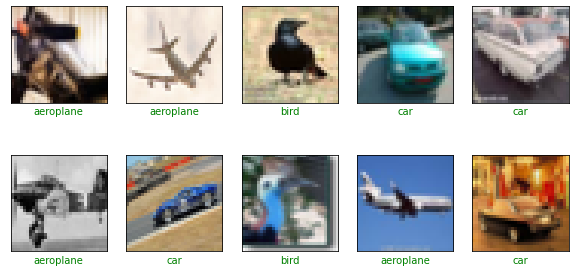

In [18]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

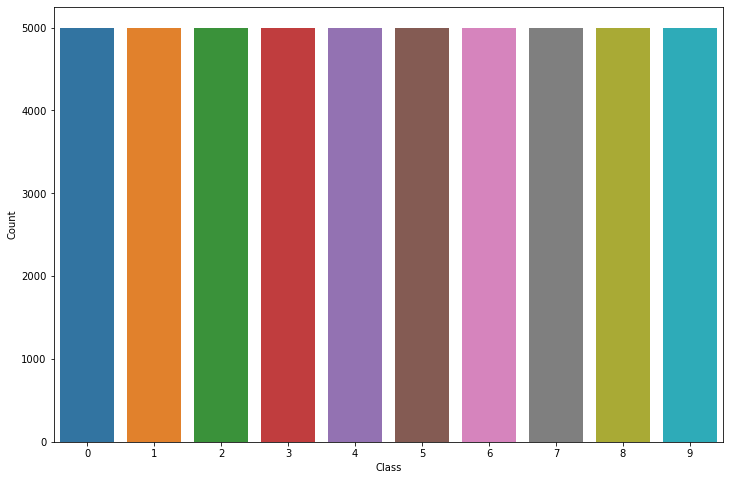

In [19]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [20]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [21]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=seed_val
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [22]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [23]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# STOP SETUP HERE

## Experiment 9

- CNN with 3 layers/max pooling layers
- Dropout(0.3)
- L2 Regularization(0.001)
- Batch Normalization

In [61]:
k.clear_session()
model_09 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
#  Dense(units=384,activation=tf.nn.relu),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [62]:
model_09.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

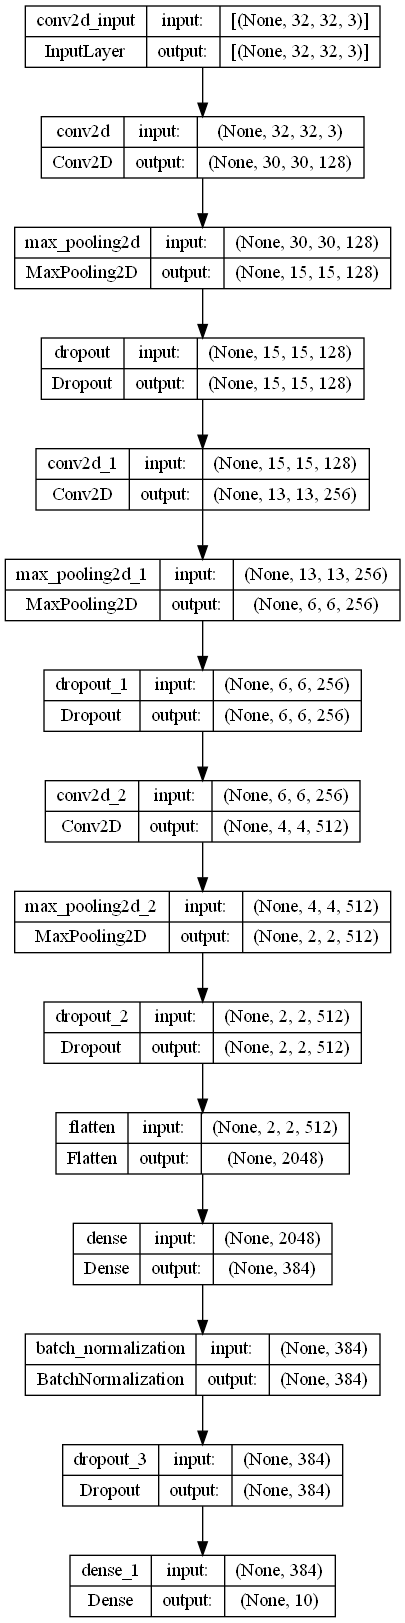

In [63]:
keras.utils.plot_model(model_09, "CIFAR10_EXP_09.png", show_shapes=True) 

In [64]:
model_09.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [65]:
history_09 = model_09.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_09_3CNN_DO_L2_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 12ms/step - loss: 2.0020 - accuracy: 0.4031 - val_loss: 1.5371 - val_accuracy: 0.5212
Epoch 2/200
704/704 [==============================] - 8s 12ms/step - loss: 1.3800 - accuracy: 0.5716 - val_loss: 1.2091 - val_accuracy: 0.6252
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 1.1858 - accuracy: 0.6350 - val_loss: 1.0853 - val_accuracy: 0.6600
Epoch 4/200
704/704 [==============================] - 8s 11ms/step - loss: 1.0886 - accuracy: 0.6680 - val_loss: 1.0108 - val_accuracy: 0.7048
Epoch 5/200
704/704 [==============================] - 8s 11ms/step - loss: 1.0436 - accuracy: 0.6871 - val_loss: 1.0328 - val_accuracy: 0.6772
Epoch 6/200
704/704 [==============================] - 8s 11ms/step - loss: 0.9955 - accuracy: 0.7069 - val_loss: 1.0566 - val_accuracy: 0.6690
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 0.9720 - accuracy: 0.7175 - val_loss: 0.9753 - val_accuracy

In [66]:
model_09 = tf.keras.models.load_model("A2_Exp_09_3CNN_DO_L2_BN.h5") # Dropout, L2 Reg, Batch Norm
print(f"Test acc: {model_09.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.7566 - accuracy: 0.7957
Test acc: 0.796


In [67]:
pred09 = model_09.predict(x_test_norm)
print('shape of preds: ', pred09.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [68]:
history_09_dict = history_09.history
history_09_df=pd.DataFrame(history_09_dict)
history_09_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
32,0.609,0.841,0.765,0.796
33,0.611,0.840,0.787,0.790
34,0.597,0.844,0.775,0.792
35,0.587,0.848,0.798,0.782
36,0.586,0.848,0.777,0.788


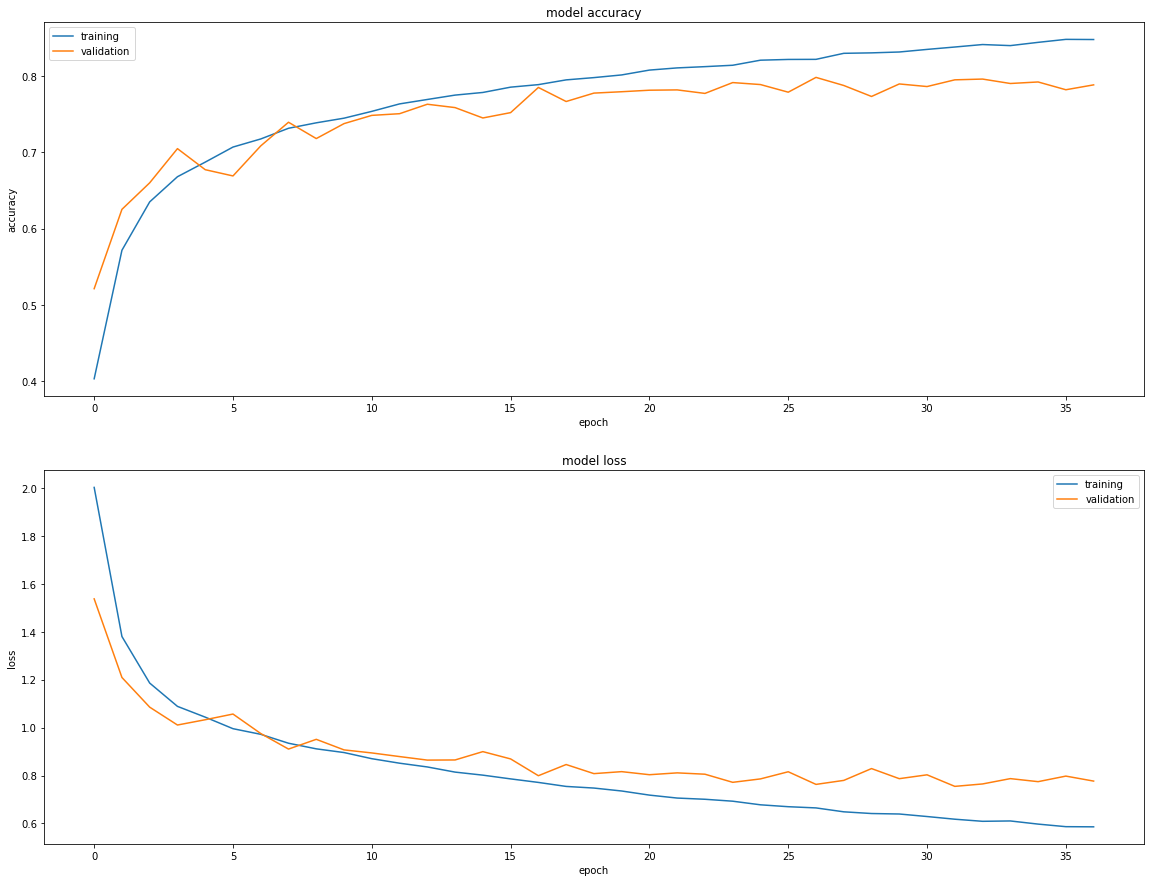

In [69]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_09.history['accuracy'], history_09.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_09.history['loss'], history_09.history['val_loss'], 'loss', 212)

In [70]:
pred09_cm=np.argmax(pred09, axis=1)
print_validation_report(y_test, pred09_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1000
           1       0.92      0.89      0.90      1000
           2       0.69      0.72      0.71      1000
           3       0.67      0.55      0.61      1000
           4       0.73      0.81      0.77      1000
           5       0.68      0.77      0.72      1000
           6       0.82      0.86      0.84      1000
           7       0.89      0.79      0.84      1000
           8       0.90      0.87      0.88      1000
           9       0.84      0.88      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Accuracy Score: 0.7957
Root Mean Square Error: 1.8114358945322906


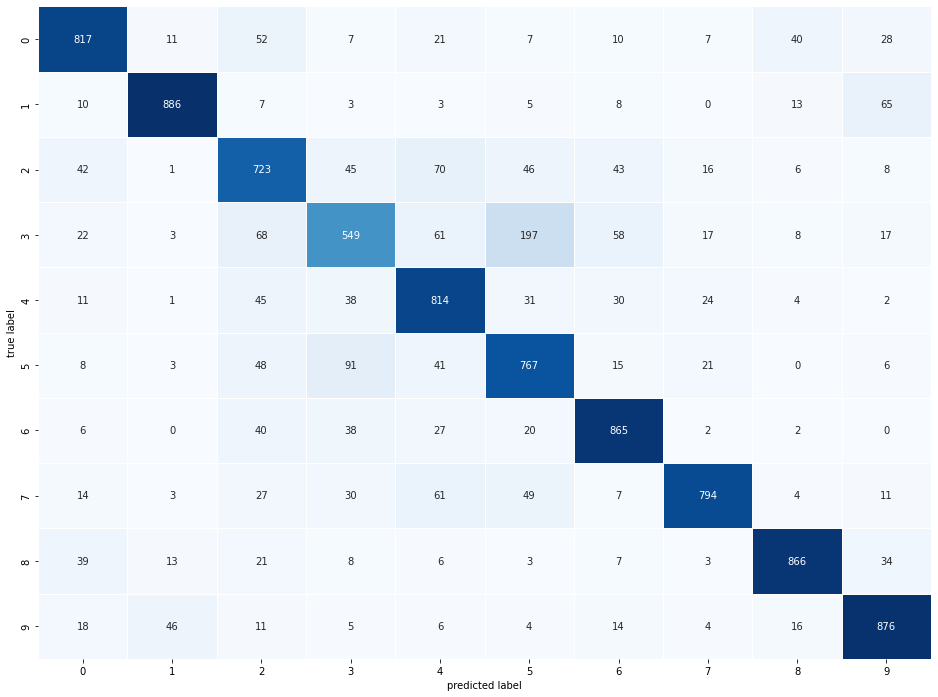

In [71]:
plot_confusion_matrix(y_test,pred09_cm)

In [72]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred09[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.62%,0.01%,1.03%,37.65%,0.32%,57.30%,2.78%,0.16%,0.11%,0.02%
1,0.57%,4.96%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,94.37%,0.09%
2,4.37%,5.71%,0.37%,0.07%,0.09%,0.02%,0.05%,0.19%,87.89%,1.24%
3,89.18%,2.50%,2.43%,0.16%,0.14%,0.02%,0.23%,0.02%,5.17%,0.16%
4,0.00%,0.00%,0.22%,0.12%,0.48%,0.01%,99.17%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.04%,0.38%,0.10%,0.31%,99.15%,0.00%,0.01%,0.00%
6,0.01%,29.13%,0.01%,0.25%,0.00%,0.19%,0.12%,0.00%,0.01%,70.28%
7,2.91%,0.03%,46.45%,2.53%,14.10%,1.05%,31.89%,0.69%,0.16%,0.20%
8,0.03%,0.00%,0.40%,90.89%,1.24%,5.12%,1.28%,1.03%,0.01%,0.01%
9,0.06%,63.35%,0.20%,0.09%,0.01%,0.07%,1.49%,0.01%,0.14%,34.58%


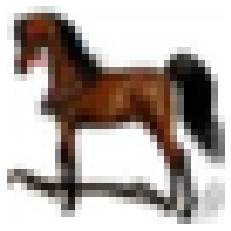

In [73]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [74]:
layer_names = []
for layer in model_09.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1']

In [75]:
# Extracts the outputs of the top 11 layers:
layer_outputs_09 = [layer.output for layer in model_09.layers[:14]]
# Creates a model that will return these outputs, given the model input:
activation_model_09 = tf.keras.models.Model(inputs=model_09.input, outputs=layer_outputs_09)

# Get activation values for the last dense layer
# activations_09 = activation_model_09.predict(x_valid_norm[:3250])
activations_09 = activation_model_09.predict(x_valid_norm[:1200])
dense_layer_activations_09 = activations_09[-4]
output_layer_activations_09 = activations_09[-1]

38/38 [==============================] - 0s 8ms/step


In [76]:
activations_09[-3].shape

(1200, 384)

In [77]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_09 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_09 = tsne_09.fit_transform(dense_layer_activations_09)

# Scaling
tsne_results_09 = (tsne_results_09 - tsne_results_09.min()) / (tsne_results_09.max() - tsne_results_09.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 2.641924


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.205212
[t-SNE] KL divergence after 300 iterations: 1.150023


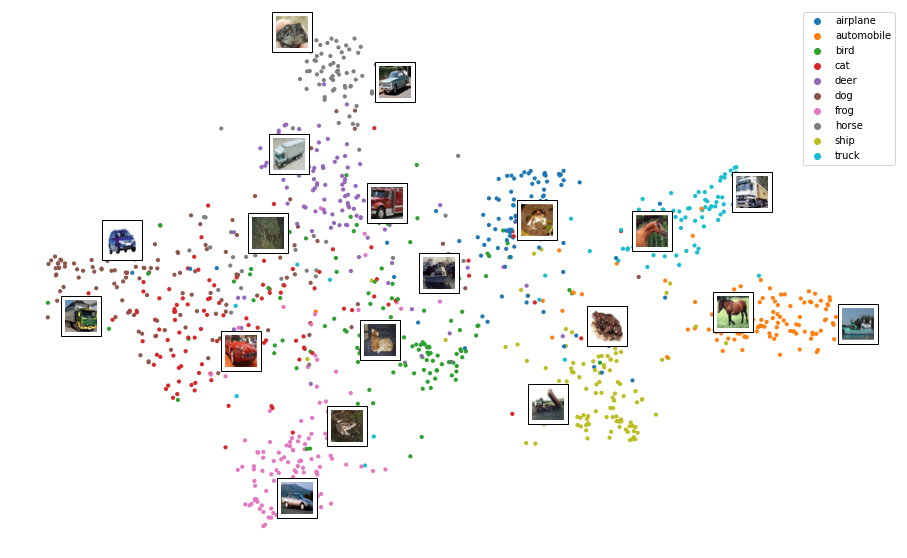

In [78]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_09[:,0],tsne_results_09[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_09[:,0],tsne_results_09[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_09):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [79]:
activations_cnn_09 = activation_model_09.predict(img_tensor)
len(activations_cnn_09)

1/1 [==============================] - 0s 353ms/step


14

C:\Users\Reed\AppData\Local\Temp\ipykernel_3740\879698534.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


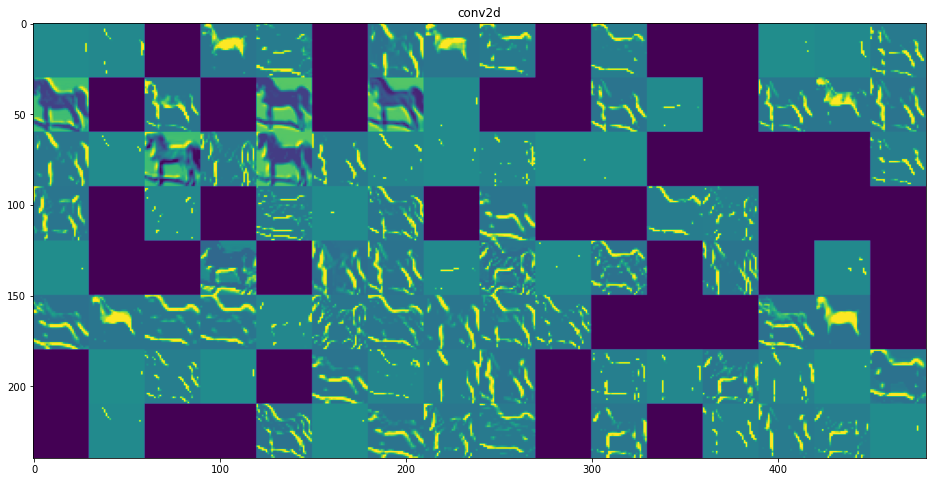

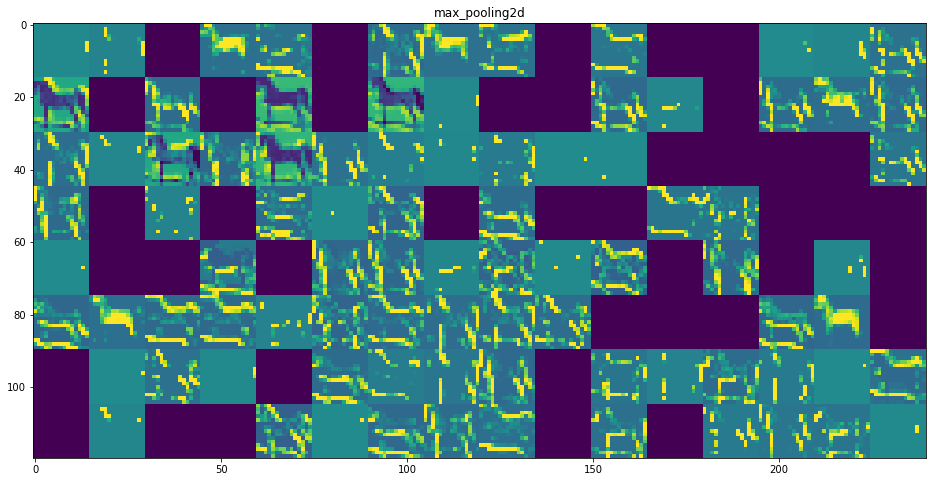

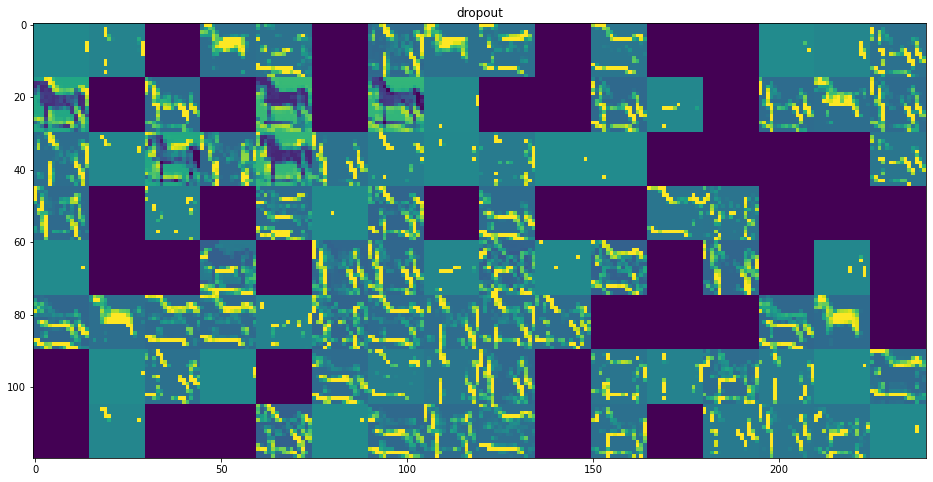

In [80]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_09.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_09):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

## Experiment 10

- CNN with 3 layers/max pooling layers
- 2 Fully-Connected Hidden Layers
- Dropout(0.3)
- L2 Regularization(0.001)
- Batch Normalization

In [81]:
k.clear_session()
model_10 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [82]:
model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

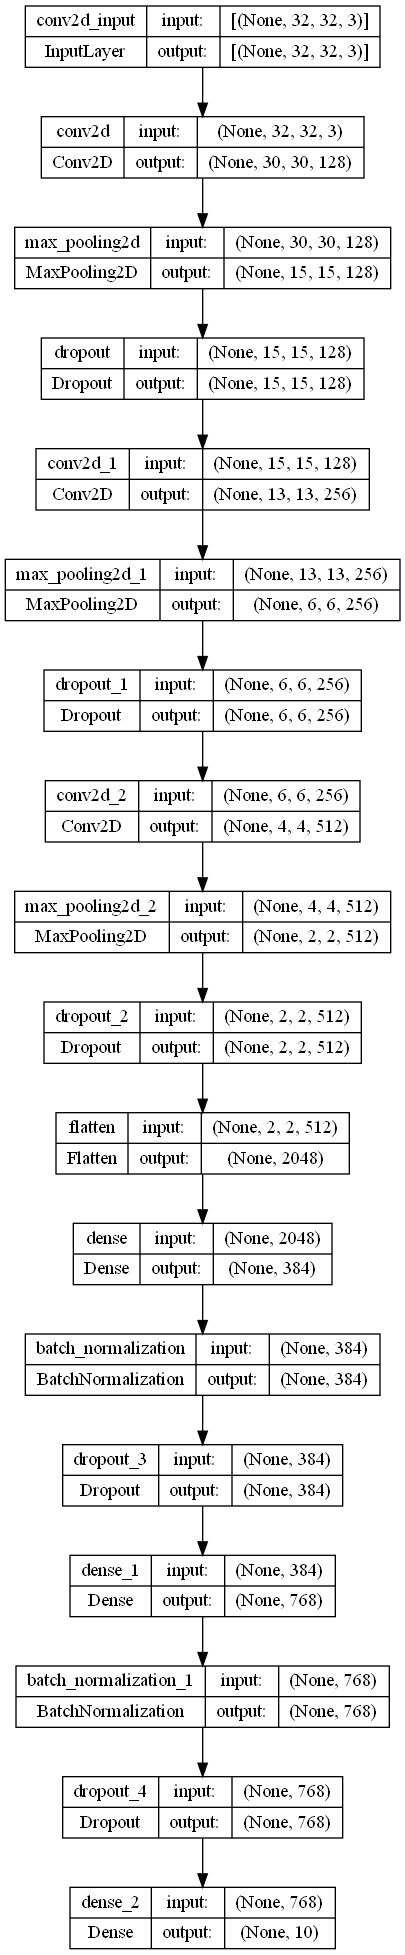

In [83]:
keras.utils.plot_model(model_10, "CIFAR10_EXP_10.png", show_shapes=True) 

In [84]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [85]:
history_10 = model_10.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_10_3CNN_2DNN_DO_L2_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 14ms/step - loss: 2.7614 - accuracy: 0.3132 - val_loss: 2.0332 - val_accuracy: 0.4474
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 1.8245 - accuracy: 0.5081 - val_loss: 1.6779 - val_accuracy: 0.5252
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 1.4982 - accuracy: 0.5812 - val_loss: 1.3357 - val_accuracy: 0.6216
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 1.3214 - accuracy: 0.6272 - val_loss: 1.2485 - val_accuracy: 0.6470
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 1.2287 - accuracy: 0.6490 - val_loss: 1.1321 - val_accuracy: 0.6626
Epoch 6/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1623 - accuracy: 0.6735 - val_loss: 1.1855 - val_accuracy: 0.6650
Epoch 7/200
704/704 [==============================] - 10s 14ms/step - loss: 1.1256 - accuracy: 0.6871 - val_loss: 1.0281 - val_accurac

In [86]:
model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_DO_L2_BN.h5") # Dropout, L2 Reg, Batch Norm
print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.7597 - accuracy: 0.8048
Test acc: 0.805


In [30]:
pred10 = model_10.predict(x_test_norm)
print('shape of preds: ', pred10.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [31]:
history_10_dict = history_10.history
history_10_df=pd.DataFrame(history_10_dict)
history_10_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
51,0.620,0.820,0.693,0.800
52,0.612,0.823,0.718,0.788
53,0.605,0.825,0.701,0.798
54,0.605,0.824,0.751,0.775
55,0.601,0.826,0.694,0.798


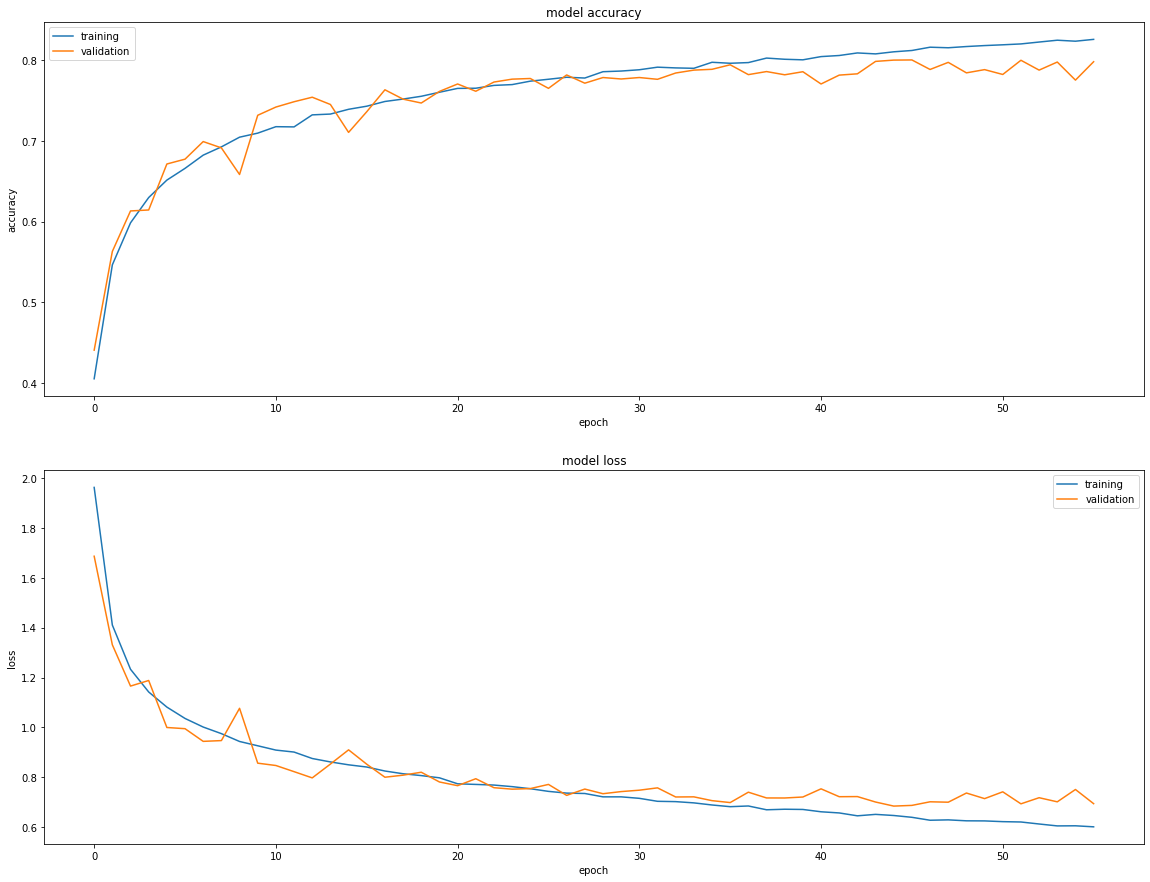

In [32]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

In [33]:
pred10_cm=np.argmax(pred10, axis=1)
print_validation_report(y_test, pred10_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1000
           1       0.93      0.88      0.91      1000
           2       0.73      0.70      0.72      1000
           3       0.74      0.56      0.63      1000
           4       0.70      0.86      0.77      1000
           5       0.74      0.71      0.73      1000
           6       0.83      0.89      0.86      1000
           7       0.84      0.84      0.84      1000
           8       0.84      0.93      0.88      1000
           9       0.88      0.88      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000

Accuracy Score: 0.8055
Root Mean Square Error: 1.7706213598621248


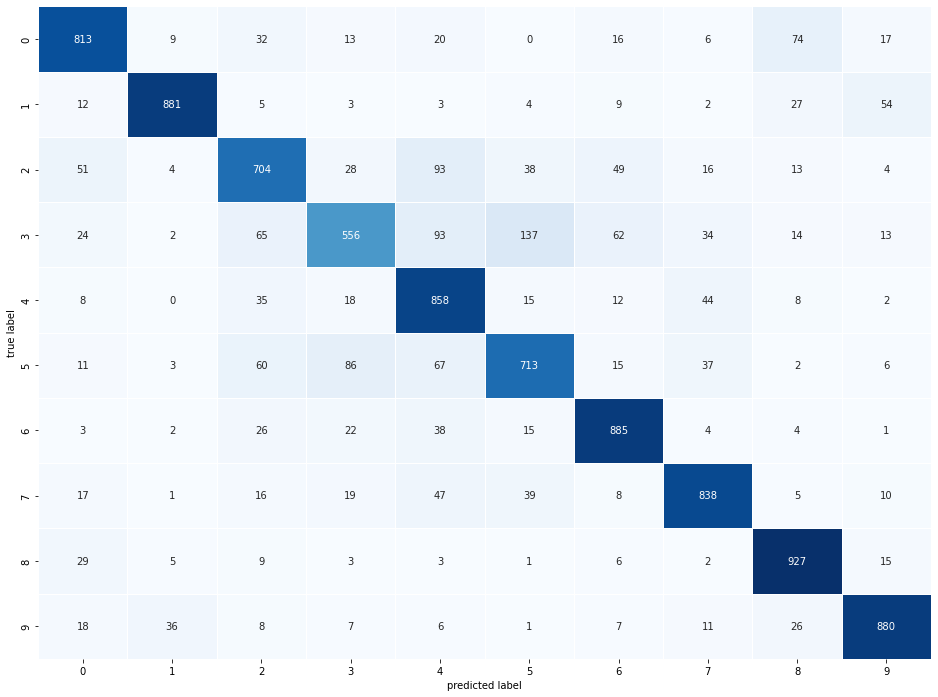

In [34]:
plot_confusion_matrix(y_test,pred10_cm)

In [35]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred10[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.06%,0.00%,0.76%,94.73%,0.71%,2.59%,0.69%,0.13%,0.29%,0.03%
1,1.65%,1.67%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,96.66%,0.01%
2,9.02%,3.36%,0.97%,1.30%,0.36%,0.34%,1.91%,0.47%,79.32%,2.94%
3,71.67%,0.08%,0.97%,0.02%,0.10%,0.00%,0.06%,0.01%,27.08%,0.02%
4,0.00%,0.00%,0.88%,0.15%,5.83%,0.01%,93.11%,0.00%,0.01%,0.00%
5,0.01%,0.00%,0.17%,0.27%,1.85%,0.18%,97.47%,0.02%,0.02%,0.00%
6,0.14%,35.76%,0.20%,0.49%,0.05%,0.72%,0.29%,0.30%,0.04%,62.01%
7,0.33%,0.03%,17.58%,8.32%,4.72%,1.80%,66.81%,0.26%,0.04%,0.10%
8,0.14%,0.01%,1.41%,75.94%,7.77%,8.71%,1.10%,4.85%,0.04%,0.02%
9,0.44%,42.89%,0.40%,0.27%,0.07%,0.42%,23.40%,0.04%,0.74%,31.34%


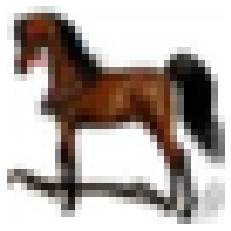

In [36]:
# (_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# img = test_images[2004]
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)

# class_names = ['airplane'
# ,'automobile'
# ,'bird'
# ,'cat'
# ,'deer'
# ,'dog'
# ,'frog' 
# ,'horse'
# ,'ship'
# ,'truck']

# plt.imshow(img, cmap='viridis')
# plt.axis('off')
# plt.show()

In [37]:
layer_names = []
for layer in model_10.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1']

In [58]:
# Extracts the outputs of the top 11 layers:
layer_outputs_10 = [layer.output for layer in model_10.layers[:14]]
# Creates a model that will return these outputs, given the model input:
activation_model_10 = tf.keras.models.Model(inputs=model_10.input, outputs=layer_outputs_10)

# Get activation values for the last dense layer
# activations_10 = activation_model_10.predict(x_valid_norm[:3250])
activations_10 = activation_model_10.predict(x_valid_norm[:1200])
dense_layer_activations_10 = activations_10[-4]
output_layer_activations_10 = activations_10[-1]

38/38 [==============================] - 0s 11ms/step


In [59]:
activations_10[-3].shape

(1200, 384)

In [47]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_10 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_10 = tsne_10.fit_transform(dense_layer_activations_10)

# Scaling
tsne_results_10 = (tsne_results_10 - tsne_results_10.min()) / (tsne_results_10.max() - tsne_results_10.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 2.552519


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.293163
[t-SNE] KL divergence after 300 iterations: 1.157518


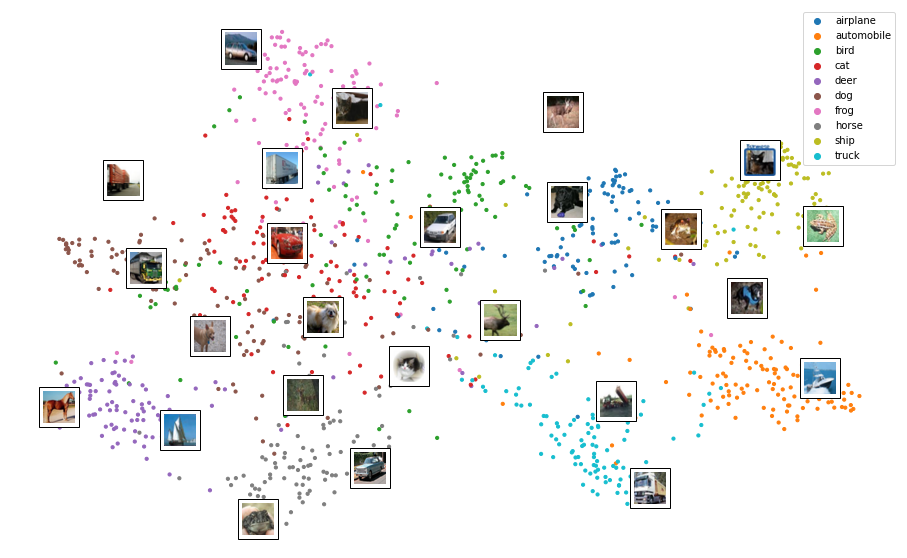

In [48]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_10[:,0],tsne_results_10[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_10[:,0],tsne_results_10[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_10):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [49]:
activations_cnn_10 = activation_model_10.predict(img_tensor)
len(activations_cnn_10)

1/1 [==============================] - 0s 241ms/step


14

C:\Users\Reed\AppData\Local\Temp\ipykernel_3740\879698534.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


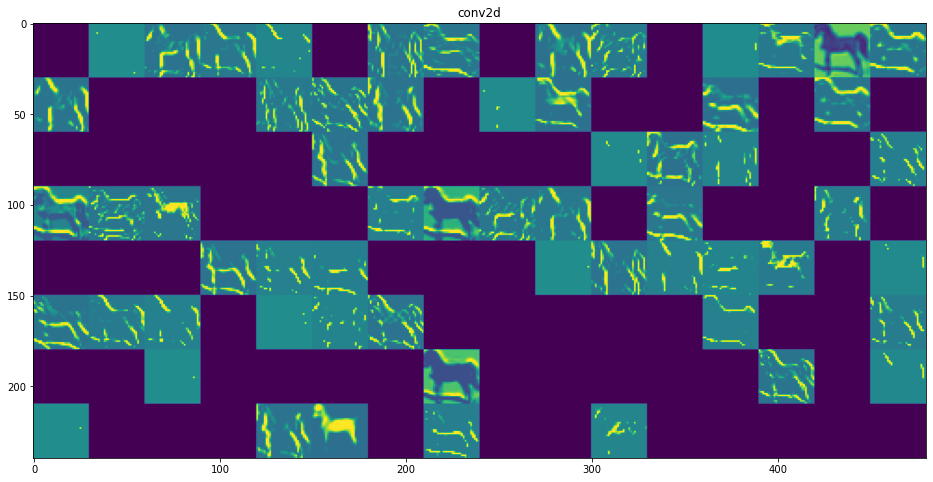

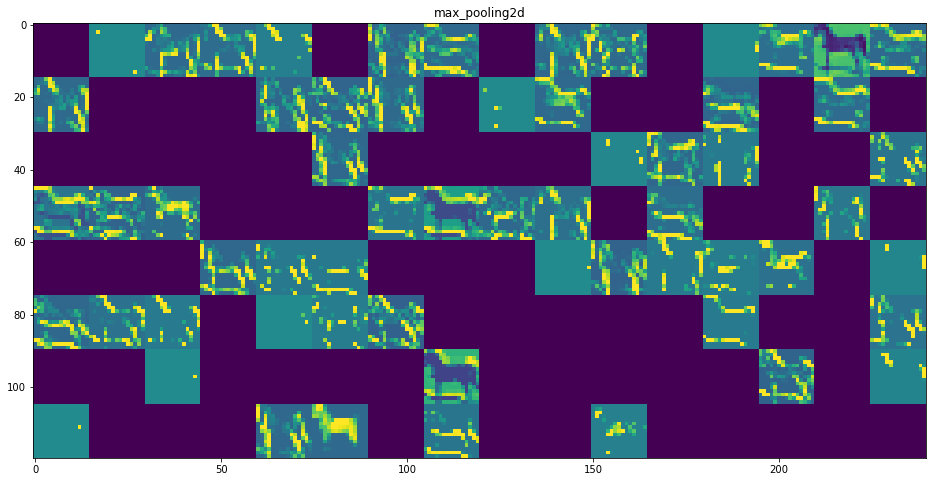

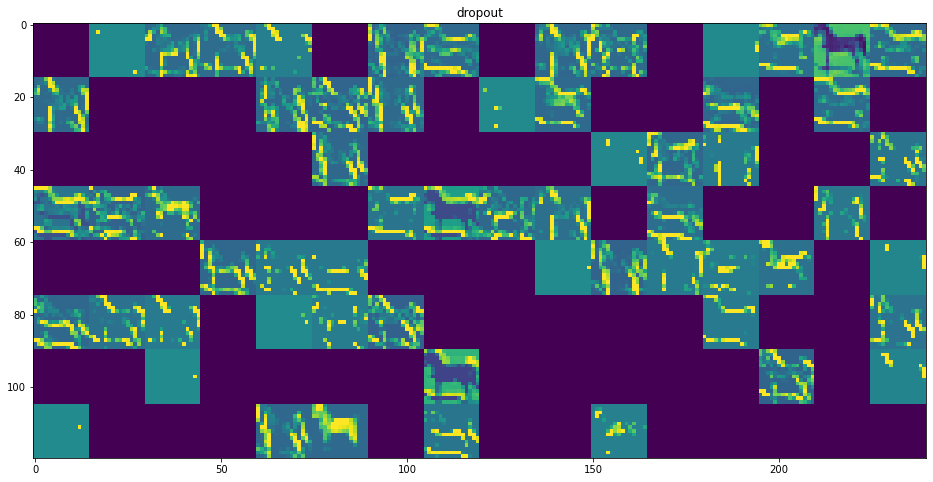

In [50]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_10.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_10):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

## Experiment 11

- CNN with 3 layers/max pooling layers
- 1 Fully-Connected Hidden Layers (384, 768, 1536 units)
- Dropout(0.3)
- L2 Regularization(0.001)
- Batch Normalization

In [105]:
k.clear_session()
model_11 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=1536,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [106]:
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

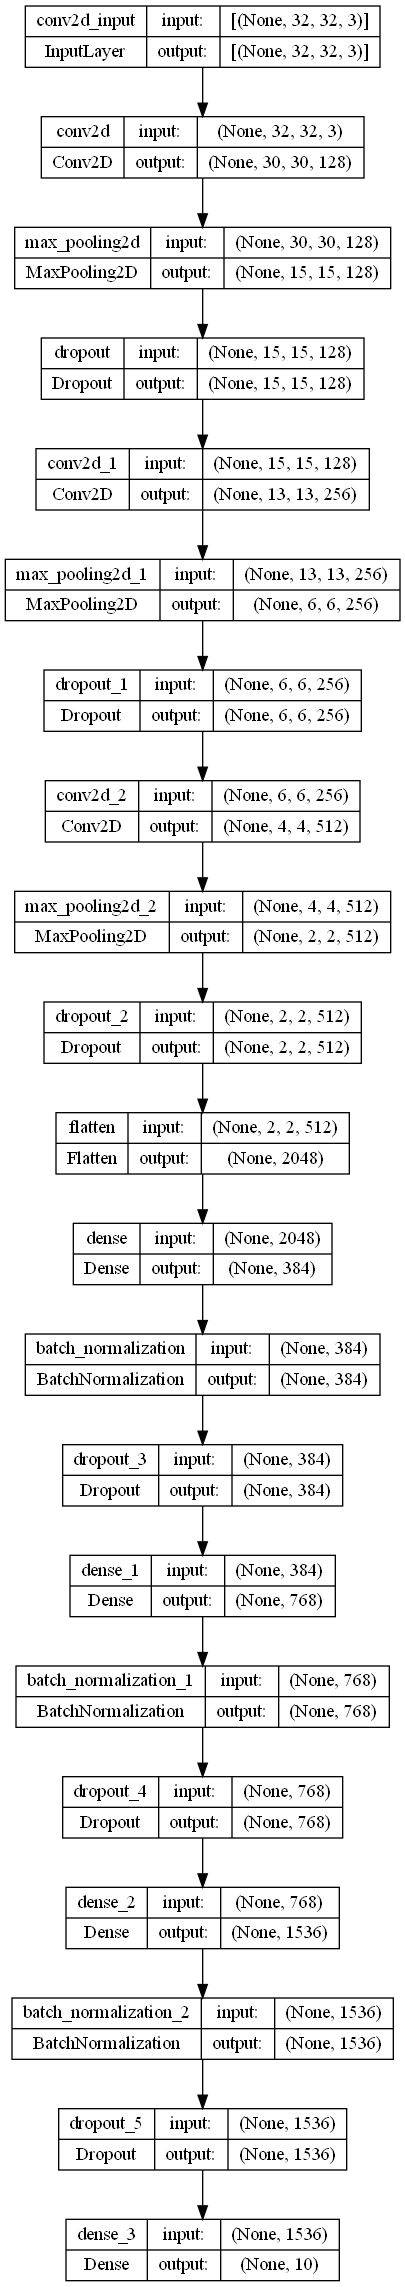

In [107]:
keras.utils.plot_model(model_11, "CIFAR11_EXP_11.png", show_shapes=True) 

In [108]:
model_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [109]:
history_11 = model_11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_11_3CNN_3DNN_DO_L2_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 13s 16ms/step - loss: 3.7822 - accuracy: 0.2904 - val_loss: 2.9182 - val_accuracy: 0.3814
Epoch 2/200
704/704 [==============================] - 11s 15ms/step - loss: 2.3328 - accuracy: 0.4603 - val_loss: 1.8988 - val_accuracy: 0.5214
Epoch 3/200
704/704 [==============================] - 11s 15ms/step - loss: 1.7882 - accuracy: 0.5364 - val_loss: 2.4425 - val_accuracy: 0.4300
Epoch 4/200
704/704 [==============================] - 12s 17ms/step - loss: 1.5918 - accuracy: 0.5733 - val_loss: 1.5908 - val_accuracy: 0.5828
Epoch 5/200
704/704 [==============================] - 13s 18ms/step - loss: 1.4954 - accuracy: 0.5980 - val_loss: 1.2845 - val_accuracy: 0.6604
Epoch 6/200
704/704 [==============================] - 12s 17ms/step - loss: 1.4421 - accuracy: 0.6211 - val_loss: 1.3993 - val_accuracy: 0.6302
Epoch 7/200
704/704 [==============================] - 11s 16ms/step - loss: 1.4129 - accuracy: 0.6405 - val_loss: 1.3060 - val_ac

In [110]:
model_11 = tf.keras.models.load_model("A2_Exp_11_3CNN_3DNN_DO_L2_BN.h5") # Dropout, L2 Reg, Batch Norm
print(f"Test acc: {model_11.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.7916 - accuracy: 0.7956
Test acc: 0.796


In [111]:
pred11 = model_11.predict(x_test_norm)
print('shape of preds: ', pred11.shape)

313/313 [==============================] - 1s 4ms/step
shape of preds:  (10000, 10)


In [112]:
history_11_dict = history_11.history
history_11_df=pd.DataFrame(history_11_dict)
history_11_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
44,0.733,0.818,0.815,0.789
45,0.727,0.820,0.823,0.788
46,0.714,0.823,0.803,0.791
47,0.709,0.824,0.812,0.788
48,0.706,0.824,0.790,0.794


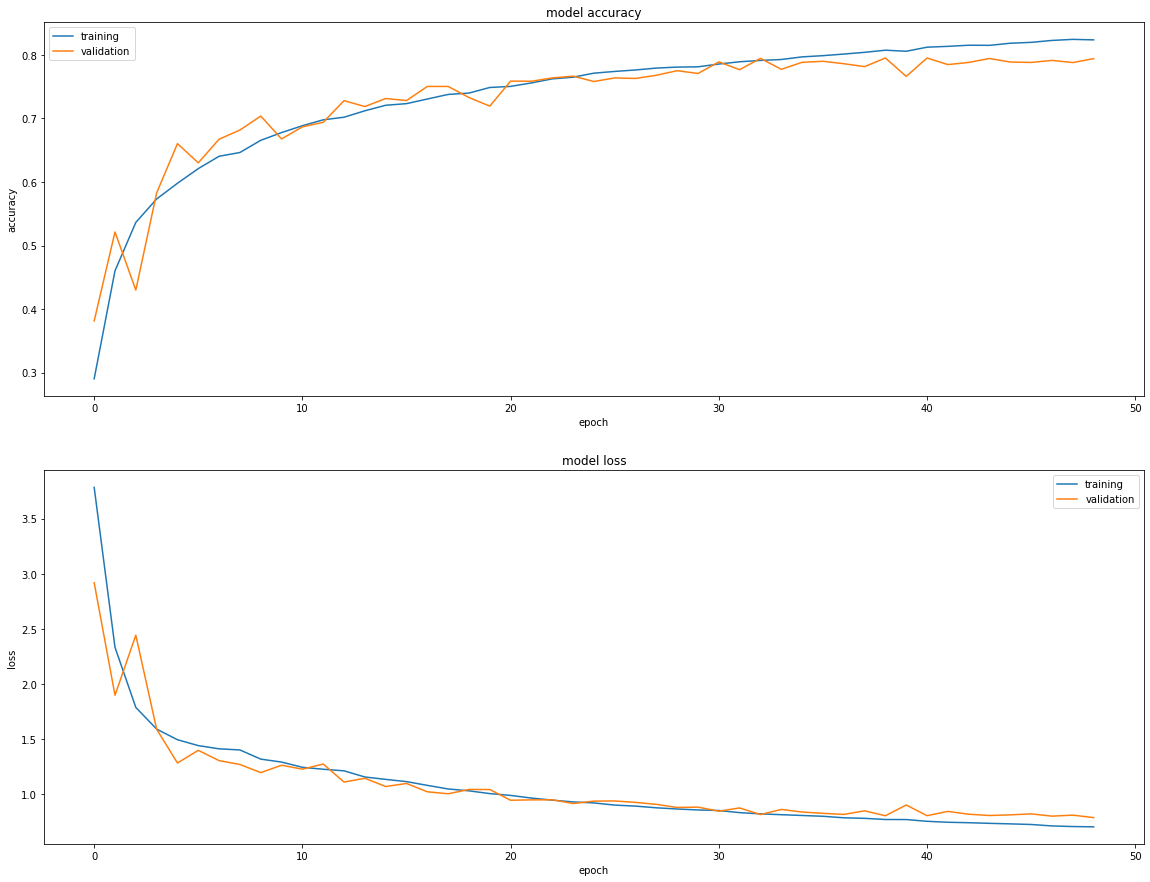

In [113]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_11.history['accuracy'], history_11.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_11.history['loss'], history_11.history['val_loss'], 'loss', 212)

In [114]:
pred11_cm=np.argmax(pred11, axis=1)
print_validation_report(y_test, pred11_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1000
           1       0.92      0.91      0.91      1000
           2       0.72      0.68      0.70      1000
           3       0.69      0.59      0.64      1000
           4       0.71      0.82      0.76      1000
           5       0.77      0.67      0.72      1000
           6       0.74      0.91      0.82      1000
           7       0.84      0.83      0.83      1000
           8       0.85      0.91      0.88      1000
           9       0.86      0.87      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000

Accuracy Score: 0.7956
Root Mean Square Error: 1.8150482087261484


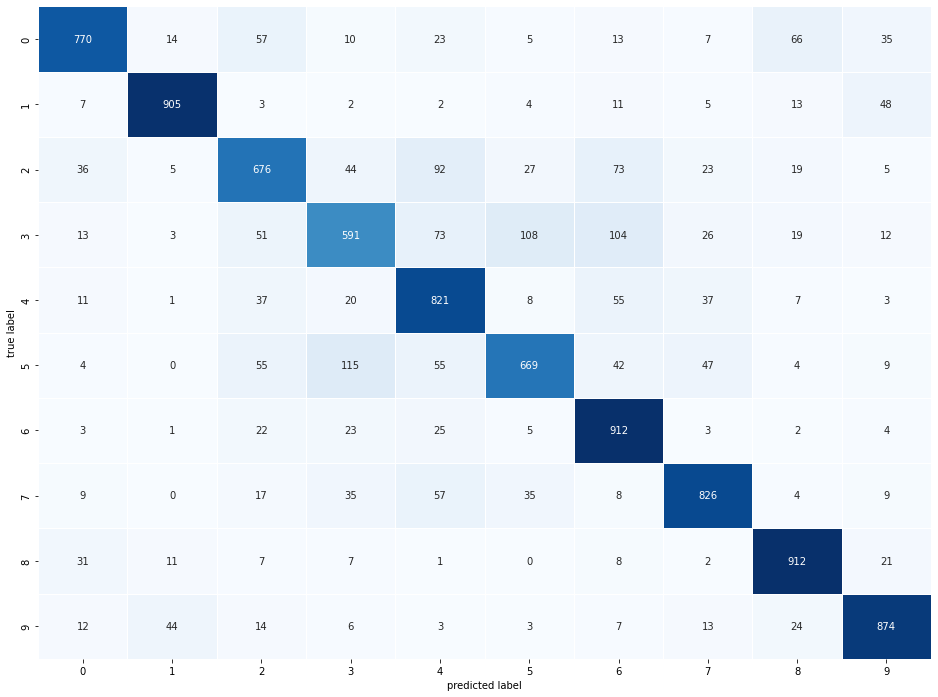

In [115]:
plot_confusion_matrix(y_test,pred11_cm)

In [116]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred11[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.36%,0.05%,0.30%,85.08%,0.21%,13.41%,0.37%,0.16%,0.03%,0.04%
1,0.67%,1.84%,0.04%,0.03%,0.03%,0.02%,0.07%,0.02%,97.03%,0.25%
2,0.57%,0.60%,0.06%,0.07%,0.05%,0.06%,0.12%,0.08%,98.11%,0.28%
3,85.42%,1.69%,1.26%,0.16%,0.62%,0.04%,0.10%,0.05%,10.11%,0.57%
4,0.08%,0.08%,0.49%,1.00%,23.62%,0.53%,74.01%,0.10%,0.04%,0.04%
5,0.01%,0.01%,0.10%,0.38%,0.11%,0.27%,99.09%,0.01%,0.01%,0.01%
6,0.04%,68.46%,0.19%,0.17%,0.01%,0.20%,0.05%,0.08%,0.02%,30.78%
7,0.21%,0.03%,8.28%,4.75%,4.61%,4.02%,77.39%,0.55%,0.06%,0.10%
8,0.05%,0.02%,0.12%,91.94%,0.92%,6.00%,0.31%,0.54%,0.03%,0.08%
9,0.30%,92.92%,0.07%,0.07%,0.03%,0.03%,0.09%,0.06%,0.11%,6.31%


In [117]:
# (_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# img = test_images[2004]
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)

# class_names = ['airplane'
# ,'automobile'
# ,'bird'
# ,'cat'
# ,'deer'
# ,'dog'
# ,'frog' 
# ,'horse'
# ,'ship'
# ,'truck']

# plt.imshow(img, cmap='viridis')
# plt.axis('off')
# plt.show()

In [118]:
layer_names = []
for layer in model_11.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1',
 'batch_normalization_1',
 'dropout_4',
 'dense_2',
 'batch_normalization_2',
 'dropout_5',
 'dense_3']

In [121]:
# Extracts the outputs of the top 11 layers:
layer_outputs_11 = [layer.output for layer in model_11.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_11 = tf.keras.models.Model(inputs=model_11.input, outputs=layer_outputs_11)

# Get activation values for the last dense layer
# activations_11 = activation_model_11.predict(x_valid_norm[:3250])
activations_11 = activation_model_11.predict(x_valid_norm[:1200])
dense_layer_activations_11 = activations_11[-4]
output_layer_activations_11 = activations_11[-1]

38/38 [==============================] - 1s 10ms/step


In [122]:
activations_11[-3].shape

(1200, 1536)

In [123]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_11 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_11 = tsne_11.fit_transform(dense_layer_activations_11)

# Scaling
tsne_results_11 = (tsne_results_11 - tsne_results_11.min()) / (tsne_results_11.max() - tsne_results_11.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.002s...
[t-SNE] Computed neighbors for 1200 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 5.042140


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.265514
[t-SNE] KL divergence after 300 iterations: 0.859058


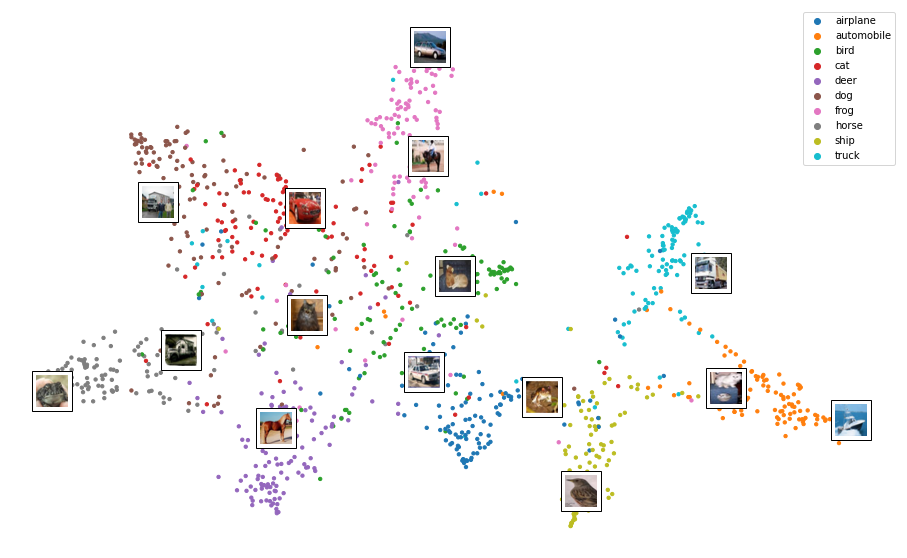

In [126]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_11[:,0],tsne_results_11[:,1], c=y_valid_split[:3250], s=11, cmap=cmap)
scatter = plt.scatter(tsne_results_11[:,0],tsne_results_11[:,1], c=y_valid_split[:1200], s=11, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_11):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [127]:
activations_cnn_11 = activation_model_11.predict(img_tensor)
len(activations_cnn_11)

1/1 [==============================] - 0s 44ms/step


20

C:\Users\Reed\AppData\Local\Temp\ipykernel_3740\3626375514.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


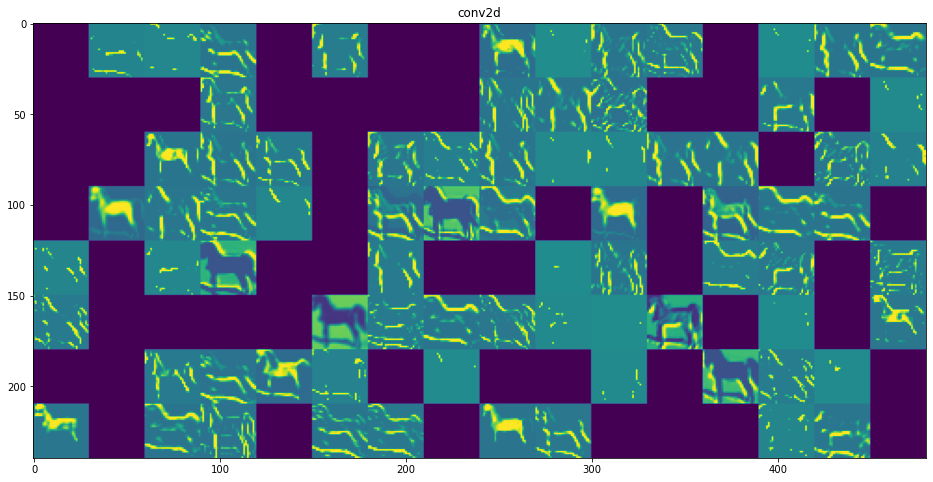

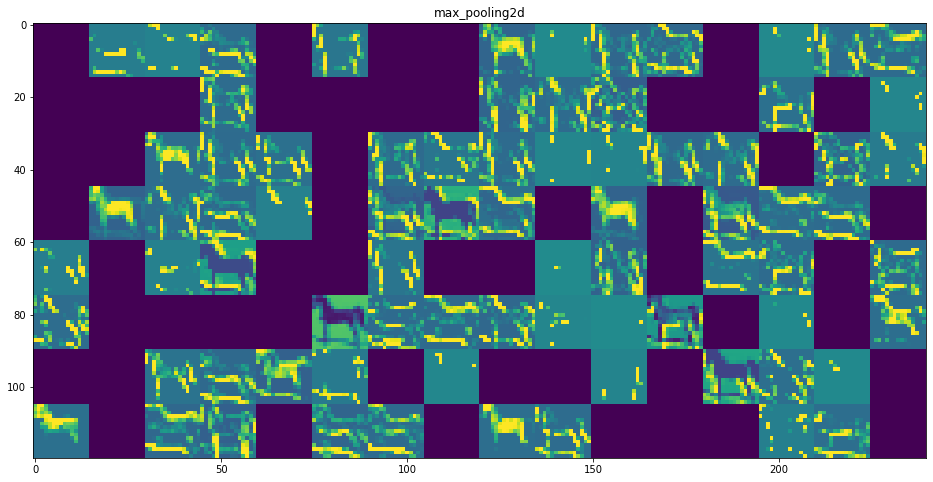

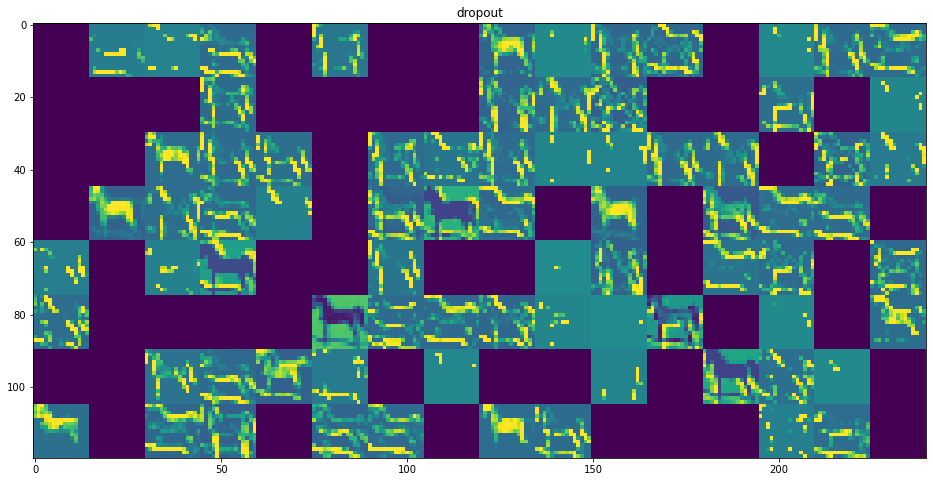

In [128]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_11.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_11):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();